### Exploramos el dataset

In [1]:
# Importar librerías
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Lecura
ruta = '../semana_5/turistas_cartagena_data.csv'
data = pd.read_csv(ruta)

In [3]:
print(data.shape)
data.head()

(500, 10)


,Fecha,Número de Visitantes,Temperatura Media (°C),Precipitación (mm),Eventos Especiales,Costo Promedio de Alojamiento (COP),Tasa de Cambio (USD/COP),Promociones de Turismo,Cantidad de Vuelos y Cruceros Disponibles,Ocupación Hotelera (%)
0,1982-12,126958.0,27.6,195.4,0.0,252889.0,3076.77,0.0,74.0,88.0
1,1983-01,136932.0,27.6,248.9,0.0,268933.0,3231.50,1.0,103.0,98.4
2,1983-02,108694.0,30.7,61.9,1.0,113428.0,3478.34,0.0,205.0,72.0
3,1983-03,124879.0,31.6,3.3,0.0,275006.0,3925.80,0.0,122.0,63.9
4,1983-04,115268.0,31.9,41.1,0.0,346627.0,3400.98,0.0,169.0,89.9


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 10 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   Fecha                                      495 non-null    object 
 1   Número de Visitantes                       485 non-null    float64
 2   Temperatura Media (°C)                     495 non-null    float64
 3   Precipitación (mm)                         495 non-null    float64
 4   Eventos Especiales                         495 non-null    float64
 5   Costo Promedio de Alojamiento (COP)        495 non-null    float64
 6   Tasa de Cambio (USD/COP)                   495 non-null    float64
 7   Promociones de Turismo                     495 non-null    float64
 8   Cantidad de Vuelos y Cruceros Disponibles  495 non-null    float64
 9   Ocupación Hotelera (%)                     495 non-null    float64
dtypes: float64(9), object(1)
m

### Limpieza de datos|

#### Datos Faltantes

In [5]:
# Imprimir registros con valores nulos a lo ancho
print(data[data.isnull().any(axis=1)])

       Fecha  Número de Visitantes  Temperatura Media (°C)  \
6        NaN                   NaN                     NaN   
7        NaN                   NaN                     NaN   
8        NaN                   NaN                     NaN   
9        NaN                   NaN                     NaN   
10       NaN                   NaN                     NaN   
12   1983-12                   NaN                    25.8   
52   1987-03                   NaN                    28.2   
57   1987-08                   NaN                    31.9   
71   1988-10                   NaN                    31.1   
114  1992-04                   NaN                    25.9   
125  1993-03                   NaN                    28.1   
140  1994-06                   NaN                    28.4   
327  2009-10                   NaN                    30.7   
377  2013-11                   NaN                    27.3   
379  2014-01                   NaN                    25.0   

     Pr

In [6]:
# Ver valores nulos
print(data.isnull().sum())

Fecha                                         5
Número de Visitantes                         15
Temperatura Media (°C)                        5
Precipitación (mm)                            5
Eventos Especiales                            5
Costo Promedio de Alojamiento (COP)           5
Tasa de Cambio (USD/COP)                      5
Promociones de Turismo                        5
Cantidad de Vuelos y Cruceros Disponibles     5
Ocupación Hotelera (%)                        5
dtype: int64


In [7]:
# Eliminar las filas completamente vacías
print(f'El tamaño del dataset antes de eliminar las filas vacías {data.shape}')
data.dropna(how='all', inplace=True)
print(f'El tamaño del dataset despues de eliminar las filas vacías {data.shape}')

El tamaño del dataset antes de eliminar las filas vacías (500, 10)
El tamaño del dataset despues de eliminar las filas vacías (495, 10)


In [8]:
# Rellenar 'Número de Visitantes' con la media
data['Número de Visitantes'] = data['Número de Visitantes'].fillna(data['Número de Visitantes'].mean())
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 495 entries, 0 to 499
Data columns (total 10 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   Fecha                                      495 non-null    object 
 1   Número de Visitantes                       495 non-null    float64
 2   Temperatura Media (°C)                     495 non-null    float64
 3   Precipitación (mm)                         495 non-null    float64
 4   Eventos Especiales                         495 non-null    float64
 5   Costo Promedio de Alojamiento (COP)        495 non-null    float64
 6   Tasa de Cambio (USD/COP)                   495 non-null    float64
 7   Promociones de Turismo                     495 non-null    float64
 8   Cantidad de Vuelos y Cruceros Disponibles  495 non-null    float64
 9   Ocupación Hotelera (%)                     495 non-null    float64
dtypes: float64(9), object(1)
memory

#### Eliminar duplicados

In [9]:
# Identificar filas duplicadas
data[data.duplicated()]

,Fecha,Número de Visitantes,Temperatura Media (°C),Precipitación (mm),Eventos Especiales,Costo Promedio de Alojamiento (COP),Tasa de Cambio (USD/COP),Promociones de Turismo,Cantidad de Vuelos y Cruceros Disponibles,Ocupación Hotelera (%)


In [10]:
# Eliminar duplicados
data.drop_duplicates(inplace=True)

#### Verificar Columnas númericas

In [11]:
data.describe()

,Número de Visitantes,Temperatura Media (°C),Precipitación (mm),Eventos Especiales,Costo Promedio de Alojamiento (COP),Tasa de Cambio (USD/COP),Promociones de Turismo,Cantidad de Vuelos y Cruceros Disponibles,Ocupación Hotelera (%)
count,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000
mean,79213.288660,28.427475,152.168485,0.187879,291329.464646,3228.464101,0.303030,177.006061,74.231717
std,42462.184309,2.038817,89.958267,0.391011,111495.245496,433.057422,0.460033,70.255966,14.271801
min,5769.000000,25.000000,-50.000000,0.000000,100781.000000,2500.200000,0.000000,50.000000,50.000000
25%,42284.500000,26.600000,70.000000,0.000000,196031.500000,2903.380000,0.000000,113.000000,61.850000
50%,81213.000000,28.400000,154.700000,0.000000,286987.000000,3214.660000,0.000000,181.000000,73.000000
75%,116688.000000,30.200000,230.800000,0.000000,383196.500000,3589.860000,1.000000,235.000000,87.050000
max,149572.000000,32.000000,299.400000,1.000000,499845.000000,3996.730000,1.000000,299.000000,100.000000


#### Outliers en variables numéricas

Usamos gráficos de boxplots para identificar datos atípicos:

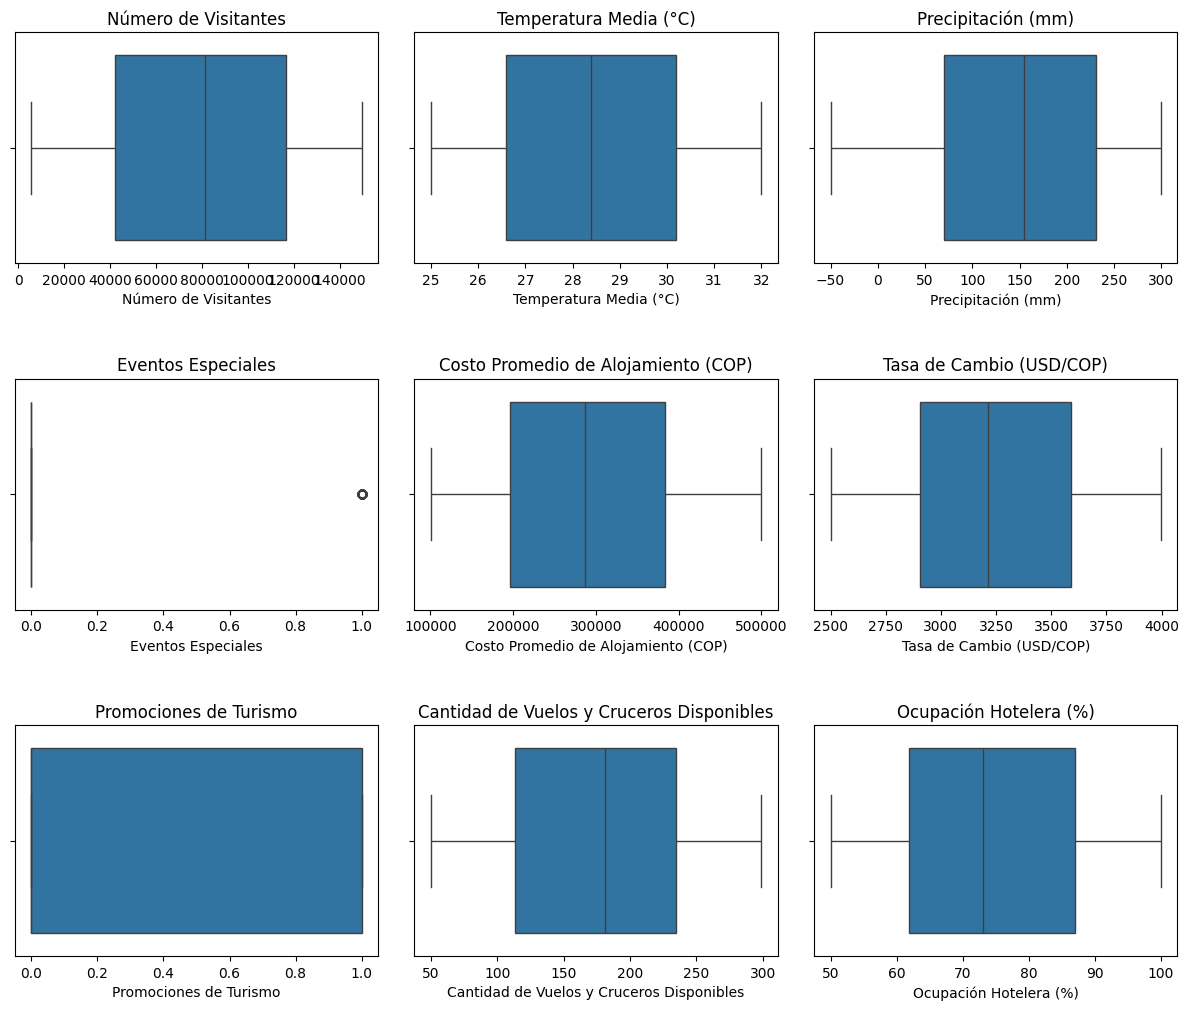

In [12]:
# Seleccionamos solo las columnas numericas
cols_num = data.select_dtypes(exclude='object').columns 

fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(15,12))
fig.subplots_adjust(hspace=0.5, wspace=0.1)

# Aplanar la matriz de ejes para un acceso más fácil
ax = ax.flatten()

# Graficamos un boxplot por cada una de las columnas
for i, col in enumerate(cols_num):
    sns.boxplot(x=col, data=data, ax=ax[i])
    ax[i].set_title(col)

plt.show()

Observaciones:
- `Precipitación mm` tiene valores por debajo de 0 mm

In [13]:
# # Eliminamos las filas con 'Precipitación mm' < 0
# print(f'Tamaño del set antes de eliminar registros de precipitación: {data.shape}')
# data = data[data['Precipitación (mm)']<0]
# print(f'Tamaño del set después de eliminar registros de precipitación: {data.shape}')

# Reemplzar los valores de precipitacion menores de 0 por la media
# Calcular el promedio solo con valores no negativos
mean_value = data.loc[data['Precipitación (mm)'] >= 0, 'Precipitación (mm)'].mean()

# Reemplazar los valores menores a 0 por el promedio corregido
data.loc[data['Precipitación (mm)'] < 0, 'Precipitación (mm)'] = mean_value

Guardamos el dataset limpio en un nuevo  archivo .csv:

In [14]:
ruta = '../semana_5/turistas_cartagena_data_clean.csv'
data.to_csv(ruta)

In [15]:
data.columns

Index(['Fecha', 'Número de Visitantes', 'Temperatura Media (°C)',
       'Precipitación (mm)', 'Eventos Especiales',
       'Costo Promedio de Alojamiento (COP)', 'Tasa de Cambio (USD/COP)',
       'Promociones de Turismo', 'Cantidad de Vuelos y Cruceros Disponibles',
       'Ocupación Hotelera (%)'],
      dtype='object')

### Modelo de regresión (predecir visitantes)

In [16]:
data.describe().loc[['max', 'min']]

,Número de Visitantes,Temperatura Media (°C),Precipitación (mm),Eventos Especiales,Costo Promedio de Alojamiento (COP),Tasa de Cambio (USD/COP),Promociones de Turismo,Cantidad de Vuelos y Cruceros Disponibles,Ocupación Hotelera (%)
max,149572.0,32.0,299.4,1.0,499845.0,3996.73,1.0,299.0,100.0
min,5769.0,25.0,1.5,0.0,100781.0,2500.20,0.0,50.0,50.0


#### Dividir el conjunto de datos en entrenamiento y prueba

In [17]:
from sklearn.model_selection import train_test_split

X = data.drop(columns=['Fecha', 'Número de Visitantes']).to_numpy()
y = data['Número de Visitantes'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=42)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(396, 8) (396,)
(99, 8) (99,)


#### Escalamiento de datos (MinMaxScaler)

Hagamos primero el escalamiento del set de entrenamiento y vemos algunas características de esta operación.

In [18]:
from sklearn.preprocessing import MinMaxScaler

x_scaler = MinMaxScaler()

# fit_transform: Calcular máximos/mínimos y escalar el set de entrenamiento
X_train_scaled = x_scaler.fit_transform(X_train)

# Algunas características del escalador
print('Características del escalador ajustado:')
print(x_scaler.data_min_) 
print(x_scaler.data_max_)

# Resultado
print('\nResultado del escalamiento sobre "X_train":')
print(f'Mínimos: {X_train_scaled.min(axis=0)}')
print(f'Máximos: {X_train_scaled.max(axis=0)}')

Características del escalador ajustado:
[2.50000e+01 1.50000e+00 0.00000e+00 1.00781e+05 2.50020e+03 0.00000e+00
 5.00000e+01 5.00000e+01]
[3.20000e+01 2.99400e+02 1.00000e+00 4.95755e+05 3.99673e+03 1.00000e+00
 2.99000e+02 9.95000e+01]

Resultado del escalamiento sobre "X_train":
Mínimos: [0. 0. 0. 0. 0. 0. 0. 0.]
Máximos: [1. 1. 1. 1. 1. 1. 1. 1.]


Ahora escalar y_train, usamos otro escalador:

In [19]:
# Ajuste para evitar errores
print(y_train.shape)
y_train = y_train.reshape(-1, 1)
print(y_train.shape)

(396,)
(396, 1)


In [20]:
y_scaler = MinMaxScaler()

# fit_transform: Calcular máximos/mínimos y escalar el set de entrenamiento
y_train_scaled = y_scaler.fit_transform(y_train)

# Algunas características del escalador
print('Características del escalador ajustado:')
print(y_scaler.data_min_) 
print(y_scaler.data_max_)

# Resultado
print('\nResultado del escalamiento sobre "y_train":')
print(f'Mínimos: {y_train_scaled.min(axis=0)}')
print(f'Máximos: {y_train_scaled.max(axis=0)}')

Características del escalador ajustado:
[6016.]
[149572.]

Resultado del escalamiento sobre "y_train":
Mínimos: [0.]
Máximos: [1.]


Ahora escalemos el set `X_test` usando el método `transform()`:

In [21]:
X_test_scaled = x_scaler.transform(X_test)

print('Set de prueba: ')
print(f'Máximos: {X_test_scaled.max(axis=0)}')
print(f'Mínimos: {X_test_scaled.min(axis=0)}')

Set de prueba: 
Máximos: [1.         0.97784491 1.         1.01035511 0.99019064 1.
 1.         1.01010101]
Mínimos: [0.01428571 0.01309164 0.         0.01094756 0.00122283 0.
 0.00401606 0.01010101]


### Entrenar el modelo

In [22]:
# Ahora si construir el modelo 
from sklearn.linear_model import LinearRegression

# Crer el modelo de regresión lineal (instancia)
lr = LinearRegression()

# Entrenar el modelo
lr.fit(X_train_scaled, y_train_scaled)

LinearRegression()

### Generar predicciones

Primero verifiquemos que las predicciones están escaladas:

In [23]:
# Predicción con el set de prueba
y_test_pred_scaled = lr.predict(X_test_scaled)

print(f'Máximo: {y_test_pred_scaled.max()}')
print(f'Mínimo: {y_test_pred_scaled.min()}')

Máximo: 0.5791734998473236
Mínimo: 0.461817168697425



Así que debemos usar `inverse_transform()` para realizar el escalamiento inverso:

In [24]:
y_test_pred = y_scaler.inverse_transform(y_test_pred_scaled)

print(f'Máximo: {y_test_pred.max():.2f}')
print(f'Mínimo: {y_test_pred.min():.2f}')

Máximo: 89159.83
Mínimo: 72312.63


Este último paso no es necesario en caso de resolver un problema de clasificación.

### Errores

In [25]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(y_test, y_test_pred)
mse = mean_squared_error(y_test, y_test_pred)
rmse = np.sqrt(mse)

print(f'Error Absoluto Medio (MAE): {mae:.2f}')
print(f'Error Cuadrático Medio (MSE): {mse:.2f}')
print(f'RMSE: {rmse:.2f}')

Error Absoluto Medio (MAE): 37270.58
Error Cuadrático Medio (MSE): 1770435124.06
RMSE: 42076.54


In [26]:
y_test_pred.shape

(99, 1)